In [72]:
# Import the necessary packages and data
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)

In [73]:
row_lengths = defaultdict(int)

for i, row in wq_df.iterrows():
    row_lengths[row.notnull().sum()] += 1

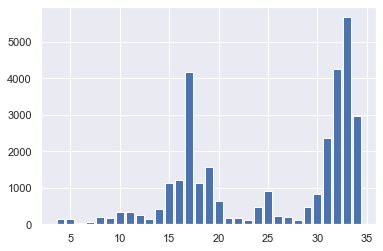

In [74]:
_ = plt.bar(x=row_lengths.keys(), height=row_lengths.values())

I want to use only rows with at least 30 columns complete. This is to prevent my data from being overloaded with imputed data.

In [75]:
for i, row in wq_df.iterrows():
    if row.notnull().sum() < 30:
        wq_df = wq_df.drop(index=i)

Next I will fill in blank values

In [76]:
ffill_df = pd.DataFrame()
for site in wq_df['Sampling Location'].unique():
    site_df = wq_df[wq_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='ffill')
    ffill_df = ffill_df.append(site_df)

In [77]:
final_df = pd.DataFrame()
for site in ffill_df['Sampling Location'].unique():
    site_df = ffill_df[ffill_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='bfill')
    final_df = final_df.append(site_df)

In [78]:
final_df = final_df.sort_index()
final_df = final_df.reset_index(drop=True)

In [79]:
# Make dummy columns for dry/wet
final_df = pd.get_dummies(final_df, columns=['Weather Condition (Dry or Wet)'])
final_df = final_df.drop(columns=['Weather Condition (Dry or Wet)_D'])
final_df

,Sampling Location,Sample Date,Sample Time,Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),Top Salinity (psu),Bottom Salinity (psu),...,Top Ortho-Phosphorus (mg/L),Top Total Kjeldhal Nitrogen (mg/L),Top Silica (mg/L),Top Total Suspended Solid (mg/L),Bottom Total Suspended Solid (mg/L),Top Active Chlorophyll 'A' (µg/L),Top Dissolved Organic Carbon (mg/L),Long,Lat,Weather Condition (Dry or Wet)_W
0,NC0,2014-02-26,10:45:00,2.51,2.46,15.0,3.0,12.0,21.66,22.01,...,0.049,1.700,1.550,11.00,9.00,29.90,3.08,-73.931556,40.714961,0
1,J7,2006-07-18,13:45:00,26.00,25.74,27.0,4.0,26.0,25.14,25.35,...,0.158,1.934,0.833,45.50,3.75,53.23,5.16,-73.820833,40.645333,0
2,N7,2011-05-18,11:30:00,13.90,13.80,53.0,3.0,51.0,17.40,24.05,...,0.068,0.717,1.715,14.00,10.00,1.40,3.00,-74.053833,40.643833,1
3,J10,2015-09-03,13:19:00,25.75,24.55,22.0,3.0,20.0,29.14,29.69,...,0.135,0.807,1.550,12.00,25.00,7.27,2.59,-73.894721,40.621667,0
4,K1,2000-08-15,11:15:00,22.56,22.10,49.0,3.3,42.6,18.15,23.92,...,0.105,0.791,2.130,3.40,1.60,1.38,3.91,-74.081945,40.651112,1
5,E14,2016-09-19,13:03:00,23.71,23.65,24.0,3.0,22.0,25.66,26.02,...,0.094,0.655,2.704,11.00,14.00,5.79,2.45,-73.864500,40.800833,1
6,N3B,2003-04-08,12:15:00,5.40,5.27,70.0,4.0,56.0,3.23,24.78,...,0.039,1.100,4.220,8.60,25.00,1.01,5.15,-73.965333,40.820833,1
7,N6,2016-06-21,15:00:00,19.17,17.64,49.0,3.0,44.0,24.41,26.37,...,0.064,0.539,0.978,19.00,38.00,8.30,2.29,-74.051333,40.664667,0
8,K5,2004-05-26,14:35:00,19.74,18.01,41.0,6.0,40.0,19.12,21.57,...,0.048,1.710,1.300,6.40,1.40,50.08,3.87,-74.258833,40.508833,1
9,E10,2011-07-05,11:08:00,19.83,16.98,83.0,3.0,56.0,23.74,24.93,...,0.068,0.712,1.320,12.00,8.00,9.80,3.90,-73.765333,40.843667,0


Different parameters will serve different purposes in my analysis. Some measurements have standard limits that must not be exceeded. The rest of the columns will be potential indicators of poor water quality. I have outlined each column's limit/indicator status below:

- Water Temperature = Indicator

- Salinity = Indicator

- Conductivity = Indicator

- Dissolved Oxygen = 3.0 mg/L

- Light Transparency = Indicator

- Sigma-T = Indicator

- Secchi Depth = Indicator

- pH = 6.0 - 9.5

- Fecal Coliform = 2000 cells/100mL

- Enterococcus = 104 cells/100mL

- Ammonia = 2.0 mg/L

- Ortho-phosphate = 0.20 mg/L

- Kjeldahl Nitrogen = 10.0 mg/L

- Silica = Indicator

- Total Suspended Solids = Indicator

- Chlorophyll a = 30

- Dissolved Organic Carbon = Indicator


In [80]:
# Make functions to 
def check_do(measure):
    if measure < 3.0:
        return 1
    else:
        return 0
    
def check_pH(measure):
    if measure > 9.5 or measure < 6.5:
        return 1
    else:
        return 0
    
def check_fecal(measure):
    if measure > 2000:
        return 1
    else:
        return 0
    
def check_enter(measure):
    if measure > 104:
        return 1
    else:
        return 0
    
def check_nitrate(measure):
    if measure > 10:
        return 1
    else:
        return 0

def check_ammonia(measure):
    if measure > 2:
        return 1
    else:
        return 0
    
def check_phosphate(measure):
    if measure > 0.20:
        return 1
    else:
        return 0
    
def check_chloro(measure):
    if measure > 30:
        return 1
    else:
        return 0
    
# Make a dictionary of each parameter with limits and assign its check function   
check_funcs = {'Top Ammonium (mg/L)':check_ammonia,
               'Top Active Chlorophyll \'A\' (µg/L)':check_chloro,
               'CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)':check_do,
               'Top Enterococci Bacteria (Cells/100mL)':check_enter,
               'Top Fecal Coliform Bacteria (Cells/100mL)':check_fecal,
               'Top Total Kjeldhal Nitrogen (mg/L)':check_nitrate,
               'Top PH':check_pH,
               'Top Ortho-Phosphorus (mg/L)':check_phosphate
              }


In [81]:
# Create columns that signify whether a measurement is outside limits
fail_col = []
for col, func in check_funcs.items():
    new_col = col + ' Failure'
    fail_col.append(new_col)
    final_df[new_col] = final_df[col].apply(func)


Taking a look at the totals for each Failure column, the most common pollutant is Ortho-phophorus by a considerable margin followed by Chlorophull A and Enterococci. I'm going to investigate these three parameters in greater depth.

In [82]:
final_df.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                              65
Top Active Chlorophyll 'A' (µg/L) Failure                                              2312
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure     742
Top Enterococci Bacteria (Cells/100mL) Failure                                         1498
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                       918
Top Total Kjeldhal Nitrogen (mg/L) Failure                                                3
Top PH Failure                                                                            6
Top Ortho-Phosphorus (mg/L) Failure                                                    1353
dtype: int64

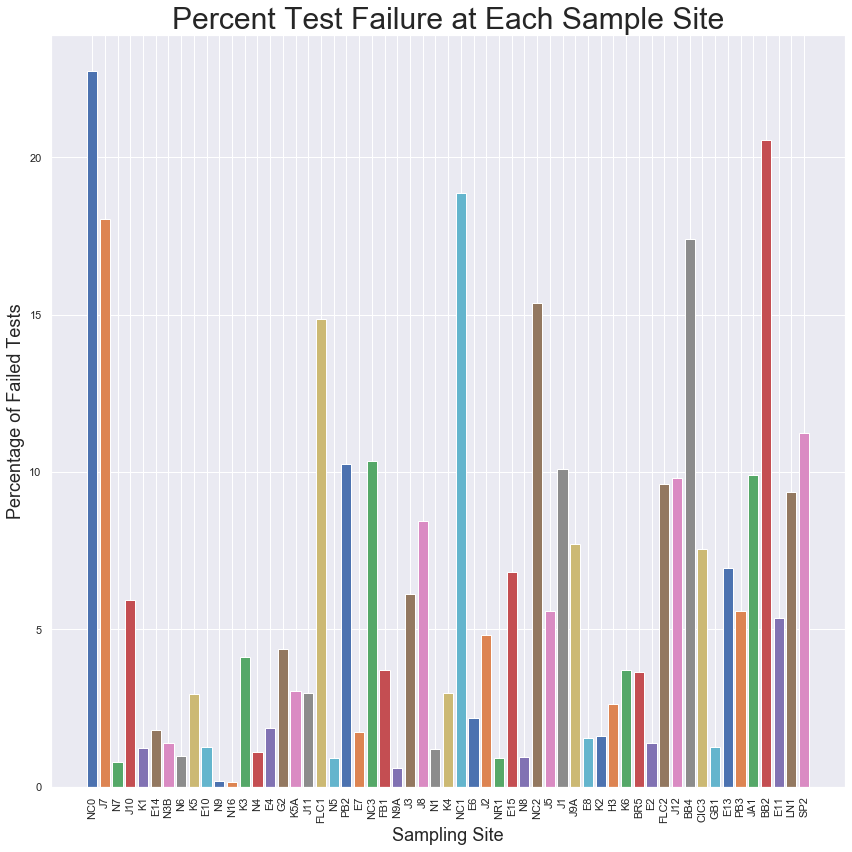

In [83]:
_ = plt.figure(figsize=(12, 12))

for location in final_df['Sampling Location'].unique():
    num = final_df[final_df['Sampling Location'] == location].loc[:, fail_col].sum().sum()
    den = final_df[final_df['Sampling Location'] == location].shape[0]
    ht = num / den / 8 * 100
    _ = plt.bar(x = location, 
            height = ht)

_ = plt.title('Percent Test Failure at Each Sample Site',
             fontsize=30)
_ = plt.xlabel('Sampling Site', fontsize=18)
_ = plt.ylabel('Percentage of Failed Tests', fontsize=18)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

I want to see if there are significant differences between samples that fail to meet EPA limits.

- The null hypothesis is that there is no significant difference between the mean values for samples that exceed limits and those that don't.
- The alternate hypothesis is that there is a significant difference between the means of both.

My original $\alpha$ value is 0.05, but since I am testing 39 columns simultaneously, I need to perform a Bonferroni correction on my $\alpha$ by dividing 0.05 by 39. After doing so, my new $\alpha$ = 0.00128.

I will be performing this for Top Enterococci Bacteria, Top Active Chlorophyll A, and Top Ortho-Phosphate.

# Compare failures to non failed starting with Enterococci

In [106]:
failed_e = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 1]
passed_e = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 0]

In [107]:
obj_col = []
for col in failed_e:
    try:
        print(col, passed_e[col].mean(), failed_e[col].mean())
    except:
        obj_col.append(col)
obj_col.append('Lat')
obj_col.append('Long')

Top Sample Temperature (ºC) 18.78067612476883 17.91068174232313
Bottom Sample Temperature (ºC) 18.083537136204814 17.483850133511346
Site Actual Depth (ft) 35.55201944805864 26.21048064085447
Top Sample Depth(ft) 3.3996767787440967 3.3753671562082785
Bottom Sample Depth (ft) 33.21540368417452 23.97656875834446
Top Salinity  (psu) 22.99673373621866 20.69286121495325
Bottom Salinity  (psu) 25.035180510853987 23.037990987983967
Top Conductivity (S/m) 3.7059425863521245 3.135635342122828
Bottom Conductivity (S/m) 3.951370757412859 3.464754453604809
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) 7.000451010066492 5.847457476635514
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L) 6.198785146887613 5.357687917222956
Light Trans (% transparency) Top Sample 58.96083477277282 58.03004579439257
Light Trans (% transparency) Bottom Sample 59.23596166289574 59.9579734312417
Top Sigma-T (kg/m3) 15.697052941176402 14.167955240320419
Bottom Sig

In [108]:
failed_e = failed_e.drop(columns=obj_col)
passed_e = passed_e.drop(columns=obj_col)

In [96]:
from statsmodels.stats import weightstats

h_o = zip(failed_e.columns, weightstats.ztest(passed_e, failed_e)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
print('Column: p-value')
for i in list(h_o):
    print(i[0], ':', sig(i[1], 0.00128))

Column: p-value
Top Sample Temperature (ºC) : Significant
Bottom Sample Temperature (ºC) : Significant
Site Actual Depth (ft) : Significant
Top Sample Depth(ft) : Not significant
Bottom Sample Depth (ft) : Significant
Top Salinity  (psu) : Significant
Bottom Salinity  (psu) : Significant
Top Conductivity (S/m) : Significant
Bottom Conductivity (S/m) : Significant
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) : Significant
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L) : Significant
Light Trans (% transparency) Top Sample : Not significant
Light Trans (% transparency) Bottom Sample : Not significant
Top Sigma-T (kg/m3) : Significant
Bottom Sigma-T (kg/m3) : Significant
Secchi Depth (ft) : Significant
Top PH : Significant
Bottom PH : Significant
Top Fecal Coliform Bacteria (Cells/100mL) : Significant
Top Enterococci Bacteria (Cells/100mL) : Significant
Top Ammonium (mg/L) : Significant
Top Ortho-Phosphorus (mg/L) : Significant

C:\Users\Drew\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Significant differences:
- Top Sample Temperature (ºC)
- Bottom Sample Temperature (ºC)
- Site Actual Depth (ft)
- Bottom Sample Depth (ft)
- Top Salinity  (psu)
- Bottom Salinity  (psu)
- Top Conductivity (S/m)
- Bottom Conductivity (S/m)
- CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)
- CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)
- Top Sigma-T (kg/m3)
- Bottom Sigma-T (kg/m3)
- Secchi Depth (ft)
- Top PH
- Bottom PH
- Top Fecal Coliform Bacteria (Cells/100mL)
- Top Enterococci Bacteria (Cells/100mL)
- Top Ammonium (mg/L)
- Top Ortho-Phosphorus (mg/L)
- Top Total Kjeldhal Nitrogen (mg/L)
- Top Silica (mg/L)
- Top Dissolved Organic Carbon (mg/L)
- Weather Condition (Dry or Wet)_W 
- Top Ammonium (mg/L) Failure
- CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
- Top Enterococci Bacteria (Cells/100mL) Failure
- Top Fecal Coliform Bacteria (Cells/100mL) Failure
- Top PH Failure
- Top Ortho-Phosphorus (mg/L) Failure

Insignificant differences:
- Top Sample Depth(ft)
- Light Trans (% transparency) Top Sample
- Light Trans (% transparency) Bottom Sample
- Top Active Chlorophyll 'A' (µg/L) Failure
- Top Total Suspended Solid (mg/L)
- Bottom Total Suspended Solid (mg/L)
- Top Active Chlorophyll 'A' (µg/L)
- Top Total Kjeldhal Nitrogen (mg/L) Failure


# Chlorophyll A Differences

In [118]:
failed_c = final_df[final_df['Top Active Chlorophyll \'A\' (µg/L) Failure'] == 1]
passed_c = final_df[final_df['Top Active Chlorophyll \'A\' (µg/L) Failure'] == 0]

In [119]:
obj_col = []
for col in failed_c:
    try:
        print(col, passed_c[col].mean(), failed_c[col].mean())
    except:
        obj_col.append(col)
obj_col.append('Lat')
obj_col.append('Long')

Top Sample Temperature (ºC) 18.45999961563559 20.12953287197228
Bottom Sample Temperature (ºC) 17.82120823119875 19.25954152249135
Site Actual Depth (ft) 36.326455870621515 24.88059688581315
Top Sample Depth(ft) 3.3866835883675415 3.4614186851211097
Bottom Sample Depth (ft) 33.96163173544133 22.778762975778545
Top Salinity  (psu) 22.484647824352816 24.55813148788932
Bottom Salinity  (psu) 24.70876144027848 25.687949826989584
Top Conductivity (S/m) 3.56247380745523 4.192089100346018
Bottom Conductivity (S/m) 3.841393816955535 4.291993944636675
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) 6.571115193270044 8.814000865051899
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L) 6.075445354993088 6.389429065743954
Light Trans (% transparency) Top Sample 60.09300200261084 51.586496095444815
Light Trans (% transparency) Bottom Sample 60.18634587868151 54.022676789587926
Top Sigma-T (kg/m3) 15.38629132279348 16.55972750865048
Bottom Sigm

In [120]:
failed_c = failed_c.drop(columns=obj_col)
passed_c = passed_c.drop(columns=obj_col)

In [121]:
from statsmodels.stats import weightstats

h_o = zip(failed_e.columns, weightstats.ztest(passed_c, failed_c)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
print('Column: p-value')
for i in list(h_o):
    print(i[0], ':', sig(i[1], 0.00128))

Column: p-value
Top Sample Temperature (ºC) : Significant
Bottom Sample Temperature (ºC) : Significant
Site Actual Depth (ft) : Significant
Top Sample Depth(ft) : Significant
Bottom Sample Depth (ft) : Significant
Top Salinity  (psu) : Significant
Bottom Salinity  (psu) : Significant
Top Conductivity (S/m) : Significant
Bottom Conductivity (S/m) : Significant
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) : Significant
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L) : Significant
Light Trans (% transparency) Top Sample : Not significant
Light Trans (% transparency) Bottom Sample : Not significant
Top Sigma-T (kg/m3) : Significant
Bottom Sigma-T (kg/m3) : Significant
Secchi Depth (ft) : Significant
Top PH : Significant
Bottom PH : Significant
Top Fecal Coliform Bacteria (Cells/100mL) : Not significant
Top Enterococci Bacteria (Cells/100mL) : Not significant
Top Ammonium (mg/L) : Significant
Top Ortho-Phosphorus (mg/L) : Signifi

C:\Users\Drew\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Significant differences:
- Top Sample Temperature (ºC)
- Bottom Sample Temperature (ºC)
- Site Actual Depth (ft)
- Top Sample Depth(ft)
- Bottom Sample Depth (ft)
- Top Salinity  (psu)
- Bottom Salinity  (psu)
- Top Conductivity (S/m)
- Bottom Conductivity (S/m)
- CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)
- CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)
- Top Sigma-T (kg/m3)
- Bottom Sigma-T (kg/m3)
- Secchi Depth (ft)
- Top PH
- Bottom PH
- Top Ammonium (mg/L)
- Top Ortho-Phosphorus (mg/L)
- Top Total Kjeldhal Nitrogen (mg/L)
- Top Silica (mg/L)
- Top Dissolved Organic Carbon (mg/L)
- Weather Condition (Dry or Wet)_W 
- Top Ammonium (mg/L) Failure
- Top Ortho-Phosphorus (mg/L) Failure

Insignificant differences:
- Light Trans (% transparency) Top Sample
- Light Trans (% transparency) Bottom Sample
- Top Fecal Coliform Bacteria (Cells/100mL)
- Top Enterococci Bacteria (Cells/100mL)
- Top Active Chlorophyll 'A' (µg/L) Failure
- Top Total Suspended Solid (mg/L)
- Bottom Total Suspended Solid (mg/L)
- Top Active Chlorophyll 'A' (µg/L)
- CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
- Top Enterococci Bacteria (Cells/100mL) Failure
- Top Fecal Coliform Bacteria (Cells/100mL) Failure
- Top Total Kjeldhal Nitrogen (mg/L) Failure
- Top PH Failure

# Ortho-Phosphate Differences

In [127]:
failed_p = final_df[final_df['Top Ortho-Phosphorus (mg/L) Failure'] == 1]
passed_p = final_df[final_df['Top Ortho-Phosphorus (mg/L) Failure'] == 0]

In [128]:
obj_col = []
for col in failed_p:
    try:
        print(col, passed_p[col].mean(), failed_p[col].mean())
    except:
        obj_col.append(col)
obj_col.append('Lat')
obj_col.append('Long')

Top Sample Temperature (ºC) 18.4248958977488 21.69552845528454
Bottom Sample Temperature (ºC) 17.74550517358284 21.104205469327432
Site Actual Depth (ft) 35.58209926769733 24.88147819660015
Top Sample Depth(ft) 3.39417412530513 3.432742054693275
Bottom Sample Depth (ft) 33.203107540005455 23.12048041389505
Top Salinity  (psu) 22.630277247762468 24.440413895048035
Bottom Salinity  (psu) 24.75845751966369 25.840295639320082
Top Conductivity (S/m) 3.630134345741801 3.900842572062084
Bottom Conductivity (S/m) 3.892210624898293 4.057462709534375
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) 6.933871535123473 6.449623059866969
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L) 6.217838757797634 5.05985957132299
Light Trans (% transparency) Top Sample 58.98706694938127 57.64064818383979
Light Trans (% transparency) Bottom Sample 59.39738084543253 58.2741957005189
Top Sigma-T (kg/m3) 15.49337815636013 16.22418329637841
Bottom Sigma-T (k

In [130]:
failed_p = failed_p.drop(columns=obj_col)
passed_p = passed_p.drop(columns=obj_col)

In [131]:
from statsmodels.stats import weightstats

h_o = zip(failed_e.columns, weightstats.ztest(passed_p, failed_p)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
print('Column: p-value')
for i in list(h_o):
    print(i[0], ':', sig(i[1], 0.00128))

Column: p-value
Top Sample Temperature (ºC) : Significant
Bottom Sample Temperature (ºC) : Significant
Site Actual Depth (ft) : Significant
Top Sample Depth(ft) : Not significant
Bottom Sample Depth (ft) : Significant
Top Salinity  (psu) : Significant
Bottom Salinity  (psu) : Significant
Top Conductivity (S/m) : Not significant
Bottom Conductivity (S/m) : Not significant
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) : Significant
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L) : Significant
Light Trans (% transparency) Top Sample : Not significant
Light Trans (% transparency) Bottom Sample : Not significant
Top Sigma-T (kg/m3) : Significant
Bottom Sigma-T (kg/m3) : Not significant
Secchi Depth (ft) : Significant
Top PH : Not significant
Bottom PH : Significant
Top Fecal Coliform Bacteria (Cells/100mL) : Significant
Top Enterococci Bacteria (Cells/100mL) : Significant
Top Ammonium (mg/L) : Significant
Top Ortho-Phosphorus (mg/

C:\Users\Drew\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Significant differences:
- Top Sample Temperature (ºC) : Significant
- Bottom Sample Temperature (ºC) : Significant
- Site Actual Depth (ft) : Significant
- Bottom Sample Depth (ft) : Significant
- Top Salinity  (psu) : Significant
- Bottom Salinity  (psu) : Significant
- CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)
- CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)
- Top Sigma-T (kg/m3) : Significant
- Secchi Depth (ft) : Significant
- Bottom PH : Significant
- Top Fecal Coliform Bacteria (Cells/100mL) : Significant
- Top Enterococci Bacteria (Cells/100mL) : Significant
- Top Ammonium (mg/L) : Significant
- Top Ortho-Phosphorus (mg/L) : Significant
- Top Total Kjeldhal Nitrogen (mg/L) : Significant
- Top Silica (mg/L) : Significant
- Bottom Total Suspended Solid (mg/L) : Significant
- Top Active Chlorophyll 'A' (µg/L) : Significant
- Top Dissolved Organic Carbon (mg/L) : Significant
- Top Ammonium (mg/L) Failure : Significant
- Top Active Chlorophyll 'A' (µg/L) Failure : Significant
- CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
- Top Enterococci Bacteria (Cells/100mL) Failure : Significant
- Top Fecal Coliform Bacteria (Cells/100mL) Failure : Significant
- Top Total Kjeldhal Nitrogen (mg/L) Failure : Significant
- Top Ortho-Phosphorus (mg/L) Failure

Not significant:
- Top Sample Depth(ft)
- Top Conductivity (S/m)
- Bottom Conductivity (S/m)
- Light Trans (% transparency) Top Sample
- Light Trans (% transparency) Bottom Sample
- Bottom Sigma-T (kg/m3)
- Top PH
- Top Total Suspended Solid (mg/L)
- Weather Condition (Dry or Wet)_W
- Top PH Failure

I want to compare sites with high failure proportions with low proportions. I will look at E2 and NC0. These are two sites that are relatively close to each other but have much different measurements.

In [52]:
nc0 = final_df[final_df['Sampling Location'] == 'NC0']
e2 = final_df[final_df['Sampling Location'] == 'E2']

In [55]:
nc0.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                             14
Top Active Chlorophyll 'A' (µg/L) Failure                                               90
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure     92
Top Enterococci Bacteria (Cells/100mL) Failure                                         159
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                       97
Top Total Kjeldhal Nitrogen (mg/L) Failure                                               0
Top PH Failure                                                                           1
Top Ortho-Phosphorus (mg/L) Failure                                                    126
dtype: int64

In [56]:
e2.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                             0
Top Active Chlorophyll 'A' (µg/L) Failure                                               1
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure    12
Top Enterococci Bacteria (Cells/100mL) Failure                                         22
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                       1
Top Total Kjeldhal Nitrogen (mg/L) Failure                                              0
Top PH Failure                                                                          0
Top Ortho-Phosphorus (mg/L) Failure                                                     6
dtype: int64